# Enigma - CDL Hackathon - Trip Generator





In [1]:
import networkx as nx
from collections import defaultdict
from dimod import BinaryQuadraticModel
from tabu import TabuSampler        
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridSampler
import neal
from strawberryfields.apps import plot
import plotly
import numpy as np
import csv
from flightHelper import *

## Running the Anneal

Initialize the problem solver.
Provide data source and applicable home bases

    ex: gen = Anneal(dataset="DS2b.csv",homebases={ "LCA" : 1 })

Minimum Dep 600
Maximum Arr 1125


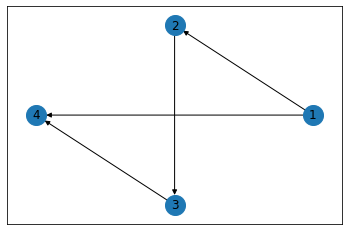

In [2]:

# Choose a data set or leave blank to use the default test case

#gen = Anneal(dataset="AirlineDataSets/DS4.csv",homebases={ "MIA" : 1 },atypes=[],depday=1)
#gen = Anneal(dataset="AirlineDataSets/DS2b.csv",homebases={ "LCA" : 1 },atypes=[],depday=1)
gen = Anneal(dataset="",homebases={ "LCA" : 1 },atypes=[],depday=1)

G1 = gen.buildViewGraph()
pos = nx.circular_layout(G1)
nx.draw_networkx(G1, pos=pos, node_size=400 , alpha=1)


## Prepare constraints (creates a QUBO)

In [3]:

gen.prepare()


Constraint 1: There must be exactly N selected nodes overall 10000000 -1 2 16
Acted on : 0 lins, 24 quads
Constraint 2: Node selected only in one row 10000000 -1 2 1
Acted on : 16 lins, 24 quads
Constraint 3: At least one start state 10000000 -3 2 0
Constraint 4: Only allowed edges to connect
Constraint 5a: Starting location request return to same location
Constraint 5b: Confirm returning to start lcoation
Objective 1: Base line unallocated time 1 1 2 0
Objective Acted on : 16 lins, 24 quads
Objective 2: Implement CI, gap and CO cancelling unallocated time 1 2 0


True

## Run the solver with applicable parameters

    useQPU : accepts the DWave QPU parameters (num_reads, chain_strength, ...)
    useHyb : accepts the Hybrid annealer parameter time_limit
    useNeal: accepts the neal parameters
    default: accepts the Tabu parameters

In [4]:

# Solver selection. Default is Tabu when all set to False
    
#useQPU = False
#useNeal = False
#useHyb = True

r = gen.solve(useHyb=True, time_limit = 3 )
#r = gen.solve(useHyb=False, num_reads = 1000 )

print( "Results returned: ", r)


Solving using the LeapHybridSolver...
Results returned:  1


## Output Results - Flight Sequence, Adjacency Matrix


In [5]:

print( r, " result(s) found")
print (gen.getN(), " flight segments (nodes)")
print(gen.getN()**2+gen.getN()," qubits")

R = None

Costs = []

if ( r > 0 ):
    
    gen.print_all()
    
    max = 3
    for res,Ma in gen.getAdjMatricesW():
        # Adjacency matrix output form A
        print("Adjacency Matrix A:")
        print(Ma)
        
        max = max - 1
        if ( max <= 0 ): break;

    rs = 0
    max = 3
    for res,Mb in gen.getAdjMatricesB():
        # Adjacency matrix output
        print("Adjacency Matrix B:")
        print(Mb)
        
           
        Costs.append(gen.getCost(Mb,res))
        
        rs = rs + 1
        
        # Get the reversed matrix
        
        R = gen.getRevMatrix(Mb)
        print("Reversed Matrix:")
        print(R)
        
        max = max - 1
        if ( max <= 0 ): break;

else:
    print("No Results")
        

1  result(s) found
4  flight segments (nodes)
20  qubits
Energy -60814200.000000
Start
0 1 X01 LCA ATH
1 2 X02 ATH LCA
Start
2 3 X03 LCA ATH
3 4 X04 ATH LCA
---------------
Adjacency Matrix A:
[[ 0. 60.  0.  0.]
 [ 0.  0. 30.  0.]
 [ 0.  0.  0. 65.]
 [ 0.  0.  0.  0.]]
Adjacency Matrix B:
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]
Reversed Matrix:
[[ 0. 60.  0.  0.]
 [ 0.  0. 30.  0.]
 [ 0.  0.  0. 65.]
 [ 0.  0.  0.  0.]]


# Calculation of Solution Cost

Solution Cost is based on the utilization of the resources. In the case of crew members, the cost is calculated using:

    Sum of TAFB of all trips
    
    Where:
    
    TAFB = N x (CI + CO) + FT + GR
    
    N = Number of trips in the solution
    TAFB = Sum of Time Away From Base of all trips
    CI = CheckIn time (usually 60 minutes)
    CO = CheckOut time (usually 30 minutes)
    FT = Total flight time of all segments
    GR = Total time spent on the ground between flights
    
    Cost = TAFB x C x R x Q
    
    where: 
    
    C = number of crew members on board
    R = average rate of pay per hours for the crew C
    Q = number of days the solutions will be repeated in a period
    

   


In [6]:

i = 1
for c in Costs:
    print("Solution ", i, " Cost per solution in minutes",c)
    print("hours = ", c / 60)

Solution  1  Cost per solution in minutes 553.0
hours =  9.216666666666667


# Input / Output calls

    Anneal.getAdjMatricesW() : Obtain an array of Adjacency matrices with weights
    Anneal.getAdjMatricesB() : Obtain an array of Adjacency matrices with binary 
    Anneal.getRevMatrix(Mb)  : Obtain a reverse adjacency matrix from a single adjacency matrix
